### [DRAFT]

Objectif : 
* Permettre une inférence par batch de SAM selon les deux modes : intéractif (depuis des prompts) et automatique (grille de prompt)
* Les modes seront codés en une même classe / fonction

On simplifiera l'inférence auto : 
* remove crops
* remove batch prompts `process_crops` 
* implement generator from SAM
* add processing mask (holes)  : 
	* add option
	* processing on low_res_mask or full masks

* Modify Sam model class or SamPredictor ?

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
# Ignore warnings
import warnings
from copy import deepcopy

warnings.filterwarnings("ignore")

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
from segment_any_change.utils import load_levircd_sample, show_img, load_img, flush_memory, load_sam
from magic_pen.data.process import DefaultTransform, generate_grid_prompt
from magic_pen.data.loader import load_ds, BiTemporalDataset, PromptDataset
from magic_pen.config import *
from segment_any_change.sa_dev.utils.transforms import ResizeLongestSide

In [5]:
df = load_ds(ds_name="levir-cd", data_type="train")

In [6]:
ds = BiTemporalDataset(
    name="levir-cd", 
    dtype="train", 
    transform=DefaultTransform()
)

In [9]:
dataloader = DataLoader(ds, batch_size=16)

In [10]:
len(dataloader)

28

#### Run batch

In [13]:
model_type = "vit_b"
sam = load_sam(model_type=model_type)

2024-05-21 16:55:21,877 - INFO ::  build SAM


In [19]:
n_points= 32
batch_size = 2 # bitemporal => x2

ds = BiTemporalDataset(
    name="levir-cd", 
    dtype="train", 
    transform=DefaultTransform()
)

dataloader = DataLoader(ds, batch_size=batch_size)

results = []
grid = generate_grid_prompt(32)
                      
for i_batch, batch in enumerate(dataloader):
    if i_batch == 0:
        print(batch.keys())
        print(batch["img_A"].shape)
        batch["point_coords"] = deepcopy(grid)
        batch['original_size']: IMG_SIZE
        batch["image"] = torch.cat([batch["img_A"], batch["img_B"]], axis=0)
        break

dict_keys(['img_A', 'img_B', 'label', 'index'])
torch.Size([2, 3, 1024, 1024])


#### Inference batch vectorized v2

In [22]:
n_points = 32
batch_points = np.tile(generate_grid_prompt(n_points), (batch_size*2, 1, 1))
batch_label = np.ones((batch_size*2, n_points*n_points))

In [23]:
batch_points.shape

(4, 1024, 2)

In [18]:
coords_torch = torch.as_tensor(
batch_points, dtype=torch.float, device=DEVICE
)
labels_torch = torch.as_tensor(
    batch_label, dtype=torch.int, device=DEVICE
)   

In [26]:
input_images = torch.cat([batch["img_A"], batch["img_B"]])

#### Visualize inputs

2024-05-21 12:00:04,816 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-05-21 12:00:04,831 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-05-21 12:00:04,844 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-05-21 12:00:04,858 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 1024, 1024, 3)


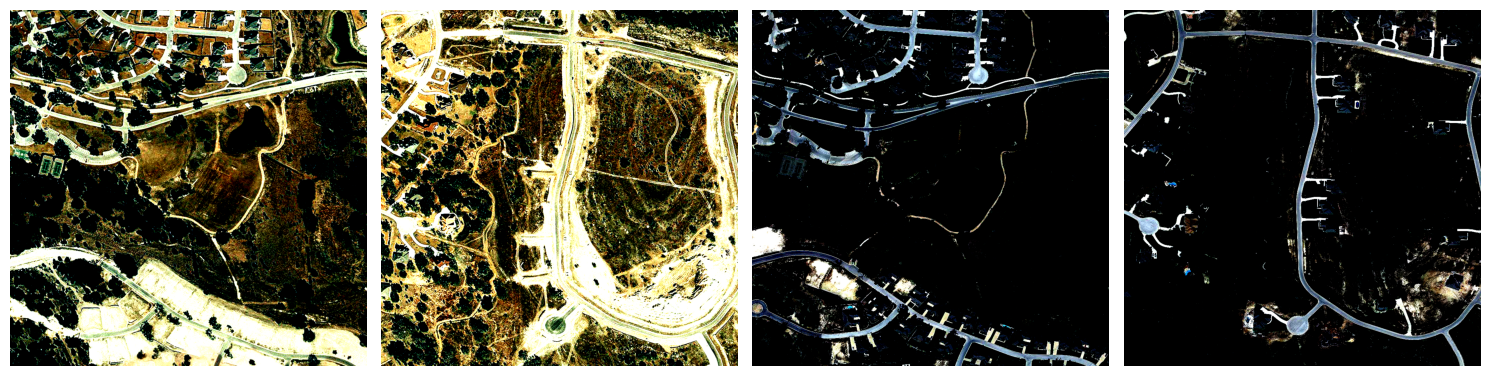

In [41]:
images = input_images.cpu().detach().numpy().transpose((0, 2, 3, 1))
print(images.shape)
fig, axes = plt.subplots(1, images.shape[0], figsize=(15, 15))
axes = axes.ravel()
for i, im in enumerate(images): 
    axes[i].imshow(im)
    axes[i].set_axis_off()
    
plt.tight_layout()

In [27]:
input_images = sam.preprocess(input_images)
image_embeddings = sam.image_encoder(input_images)

In [22]:
image_embeddings.shape

torch.Size([4, 256, 64, 64])

##### Modify prompt encoder

In [23]:
# (coords_torch[:,:,None,:], labels_torch[...,None])
sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=(coords_torch[:,:,None,:], labels_torch[...,None]),
                boxes=None,
                masks=None,
            )

bs : 1024
torch.Size([4, 1024, 0, 256])
point shape raw torch.Size([4, 1024, 1, 2])
padding_point shape raw torch.Size([4, 1024, 1, 2])
concat points and padding shape torch.Size([4, 1024, 2, 2])
emb points
torch.Size([4, 1024, 2, 256])
torch.Size([4, 1024, 2, 256])
torch.Size([4, 1024, 0, 256])
torch.Size([4, 1024, 2, 256])
torch.Size([4, 1024, 2, 256])


=> erreur dans la dimension des dense => need to be == B*N

On a ajouté la dimension des images (B) dans l'implémentation mais on aurait pu concaténer dans la même dimension B et N (nombre de points par image).

=> Les images doivent avoir le même nombre de prompts ?

=> Alors que si on fait une dimension "flat" on peut retrouver le nombre de prompt par image via des indices

=> KEEP OR NOT ? => allow gather prompts by image without set indices but does different prompt number is allowed ?

In [24]:
sparse_embeddings = sparse_embeddings.flatten(0, 1)
sparse_embeddings.shape

torch.Size([4096, 2, 256])

##### Raw prompt encoder (to keep)

In [23]:
model_type = "vit_b"
sam_raw = load_sam(model_type=model_type, version="raw")

2024-05-21 16:55:29,400 - INFO ::  build SAM


In [24]:
coords_torch = coords_torch.flatten(0, 1)
labels_torch = labels_torch.flatten(0, 1)

In [25]:
coords_torch.shape, labels_torch.shape

(torch.Size([4096, 2]), torch.Size([4096]))

In [26]:
# (coords_torch[:,:,None,:], labels_torch[...,None])
sparse_embeddings, dense_embeddings = sam_raw.prompt_encoder(
                points=(coords_torch[:,None,:], labels_torch[...,None]),
                boxes=None,
                masks=None,
            )

In [27]:
sparse_embeddings.shape

torch.Size([4096, 2, 256])

In [28]:
dense_embeddings.shape

torch.Size([4096, 256, 64, 64])

Même nombre de prompt par batch pour simplifier.

In [29]:
print(image_embeddings.shape)
print((sam.prompt_encoder.get_dense_pe()).shape)
print(sparse_embeddings.shape)
print(dense_embeddings.shape)

torch.Size([4, 256, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([4096, 2, 256])
torch.Size([4096, 256, 64, 64])


In [31]:
sparse_embeddings.shape

torch.Size([4096, 2, 256])

In [ ]:
sparse_embeddings = sparse_embeddings.reshape(image_embeddings.shape[0], -1, *sparse_embeddings.shape[-2:])

dense_embeddings = dense_embeddings.reshape(image_embeddings.shape[0], -1, *dense_embeddings.shape[-3:])

In [34]:
sparse_embeddings.shape

torch.Size([4, 1024, 2, 256])

In [35]:
dense_embeddings.shape

torch.Size([4, 1024, 256, 64, 64])

In [36]:
image_embeddings.shape

torch.Size([4, 256, 64, 64])

In [37]:
sparse_emb = torch.as_tensor(np.zeros((4, 1024, 2, 256)))
new_tokens = torch.as_tensor(np.ones((5, 256)))

In [38]:
new_tokens = new_tokens.unsqueeze(0).expand(sparse_emb.size(1), -1, -1)
new_tokens = new_tokens.unsqueeze(0).expand(sparse_emb.size(0), -1, -1, -1)


In [39]:
new_tokens.shape

torch.Size([4, 1024, 5, 256])

In [40]:
tokens = torch.cat((new_tokens, sparse_emb), dim=2)


In [41]:
tokens.shape

torch.Size([4, 1024, 7, 256])

In [42]:
image_pe = sam.prompt_encoder.get_dense_pe()

In [43]:
image_pe.shape

torch.Size([1, 256, 64, 64])

In [44]:
pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)

In [45]:
pos_src.shape

torch.Size([4, 256, 64, 64])

In [46]:
image_embeddings.shape

torch.Size([4, 256, 64, 64])

In [47]:
low_res_masks, iou_predictions = sam.mask_decoder.predict_masks_batch(
    image_embeddings=image_embeddings, # (B, 256, 64, 64)
    image_pe=sam.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings, # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
    #multimask_output=True,
)


init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([4, 1024, 5, 256])
tokens shape : torch.Size([4, 1024, 7, 256])
img_embedding (src) : torch.Size([4, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([4, 1024, 256, 64, 64])
pos_src : torch.Size([4, 1024, 256, 64, 64])
tokens : torch.Size([4, 1024, 7, 256])
- In transf src : torch.Size([4, 1024, 4096, 256])
- In transf image_pe : torch.Size([4, 1024, 4096, 256])
out transformer
hs shape : torch.Size([4, 1024, 7, 256])
src shape : torch.Size([4, 1024, 4096, 256])
iou out shape : torch.Size([4, 1024, 256])
masks tokens out shape : torch.Size([4, 1024, 4, 256])
upscaled src tokens out shape : torch.Size([4, 1024, 32, 256, 256])
hyper in shape : torch.Size([4, 1024, 4, 32])
 mask_low : torch.Size([4, 1024, 4, 256, 256])


In [49]:
low_res_masks.shape

torch.Size([4, 1024, 4, 256, 256])

In [63]:
# Upscale the masks to the original image resolution
masks = torch.stack([sam.postprocess_masks(
    _, IMG_SIZE, IMG_SIZE
) for _ in low_res_masks], dim=0)

In [53]:
masks.shape

torch.Size([4, 1024, 4, 1024, 1024])

In [54]:
masks = masks > sam.mask_threshold

In [65]:
masks = masks.cpu().detach().numpy()

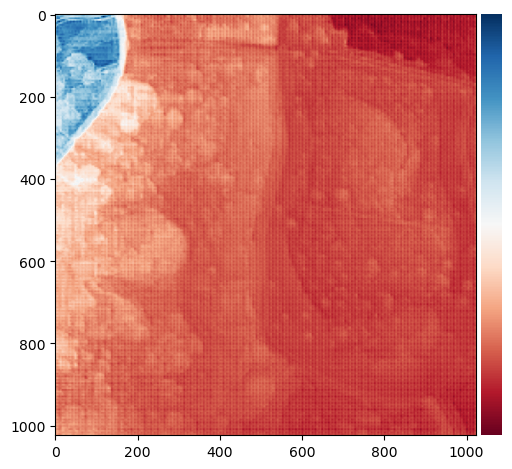

In [68]:
show_img(np.sum(masks[1, :, 0,...], axis=0))

In [42]:
images.shape

(4, 1024, 1024, 3)

In [43]:
batch["index"]

tensor([0, 1])

In [43]:
batch.keys()

dict_keys(['img_A', 'img_B', 'label', 'point_coords', 'original_size', 'image'])

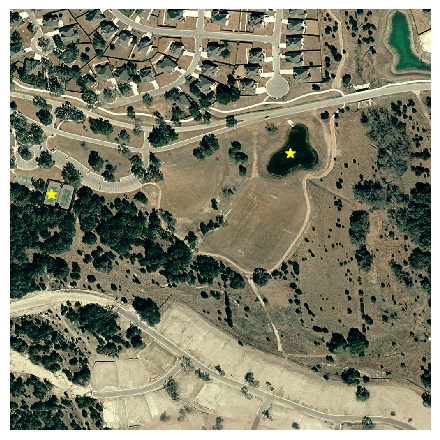

In [49]:
show_img(df["A"].iloc[0])
ax = plt.gca()
ax.scatter(*(680, 350), color='yellow', marker='*', s=50)
ax.scatter(*(100, 450), color='yellow', marker='*', s=50)

#### Infer with predictor

In [58]:
img_sample.shape

(1024, 1024, 3)

In [68]:
from segment_any_change.sa_dev_v0 import sam_model_registry, SamPredictor
from magic_pen.data.process import prepare_prompts

masks_pred = []

model_type = "vit_b"
sam = load_sam(model_type=model_type, version="raw")

predictor = SamPredictor(sam)

img_sample = load_img(df["A"].iloc[0])

coords = np.array([[680, 350], [100, 450]])
labels = np.array([1, 1])

#coords_torch, labels_torch, box_torch, mask_input_torch = prepare_prompts(coords, labels)

coords_torch = torch.as_tensor(
    coords, dtype=torch.float, device=DEVICE
)
labels_torch = torch.as_tensor(
    labels, dtype=torch.int, device=DEVICE
)
# coords_torch = predictor.transform.apply_coords_torch(coords_torch, img_sample.shape[:2])

coords_torch, labels_torch = coords_torch[:,None, :], labels_torch[..., None]
# warning : not coords_torch[None,:, :], labels_torch[None, :]

#coords_torch = torch.as_tensor(np.array([680, 350]), dtype=torch.float32, device=DEVICE)
#labels_torch = torch.as_tensor(np.array([680, 350]), dtype=torch.float32, device=DEVICE)

print(coords_torch.shape)
print(labels_torch.shape)

predictor.set_image(img_sample)
m, iou_predictions, low_res_masks = predictor.predict_torch(
    coords_torch,
    labels_torch,
    boxes=None,
    mask_input=None,
    multimask_output=True,
    return_logits=False,
)


2024-05-21 18:00:44,529 - INFO ::  build SAM


torch.Size([2, 1, 2])
torch.Size([2, 1])
---- start predict torch ----
sparse emb : torch.Size([2, 2, 256])
dense emb : torch.Size([2, 256, 64, 64])
img emb : torch.Size([1, 256, 64, 64])
init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([2, 5, 256])
tokens shape : torch.Size([2, 7, 256])
src first interleave shape : torch.Size([2, 256, 64, 64])
src shape : torch.Size([2, 256, 64, 64])
src dense_prompt_embeddings : torch.Size([2, 256, 64, 64])
src add dense : torch.Size([2, 256, 64, 64])
out transformer
hs shape : torch.Size([2, 7, 256])
src shape : torch.Size([2, 4096, 256])
iou out shape : torch.Size([2, 256])
masks tokens out shape : torch.Size([2, 4, 256])
 mask_low : torch.Size([2, 4, 256, 256])
low mask  predict torch : torch.Size([2, 3, 256, 256])
low mask  predict torch : torch.Size([2, 3, 1024, 1024])


In [69]:
m = m.cpu().detach().numpy()

In [70]:
m.shape

(2, 3, 1024, 1024)

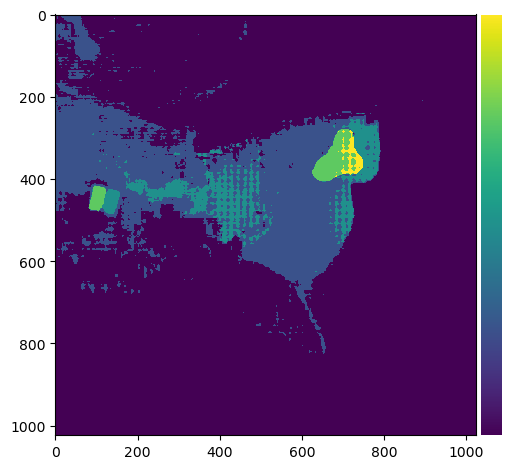

In [74]:
show_img(np.sum(m.reshape(-1, *m.shape[-2:]), axis=0))

#### Pipeline batch infer test

In [28]:
ds[0]["img_B"].shape

torch.Size([3, 1024, 1024])

In [31]:
batch["img_B"].shape

torch.Size([2, 3, 1024, 1024])

In [78]:
model_type = "vit_b"
sam = load_sam(model_type=model_type, version="dev")
index = 0

#img_sample = load_img(df["A"].iloc[0])
img_A = ds[index]["img_A"]
img_B = ds[index]["img_B"]

input_images = torch.stack([ds[index]["img_A"], ds[index]["img_B"]])
print(f"input images : {input_images.shape}")

input_images = sam.preprocess(input_images)
image_embeddings = sam.image_encoder(input_images)
print(f"image_embeddinhgs: {image_embeddings.shape}")

coords = np.array([[680, 350], [100, 450]])
labels = np.array([1, 1])

coords_torch = torch.as_tensor(
    coords[None,...], dtype=torch.float, device=DEVICE
)
labels_torch = torch.as_tensor(
    labels[None,...], dtype=torch.int, device=DEVICE
)   

# just for the encoder
model_type = "vit_b"
sam_raw = load_sam(model_type=model_type, version="raw")

coords_torch = coords_torch.flatten(0, 1) # workaround
labels_torch = labels_torch.flatten(0, 1)
# (coords_torch[:,:,None,:], labels_torch[...,None])
sparse_embeddings, dense_embeddings = sam_raw.prompt_encoder(
                points=(coords_torch[:,None,:], labels_torch[...,None]),
                boxes=None,
                masks=None,
            )
print(f"sparse_embeddings: {sparse_embeddings.shape}")
print(f"dense_embeddings: {dense_embeddings.shape}")

sparse_embeddings = sparse_embeddings.unsqueeze(0).expand(
    image_embeddings.size(0), -1, -1, -1
)
dense_embeddings = dense_embeddings.unsqueeze(0).expand(
    image_embeddings.size(0), -1, -1, -1, -1
)
# why now it's modified ?
#sparse_embeddings = sparse_embeddings.reshape(image_embeddings.shape[0], -1, *sparse_embeddings.shape[-2:])
#dense_embeddings = dense_embeddings.reshape(image_embeddings.shape[0], -1, *dense_embeddings.shape[-3:])

print(f"sparse_embeddings: {sparse_embeddings.shape}")
print(f"dense_embeddings: {dense_embeddings.shape}")

low_res_masks, iou_predictions = sam.mask_decoder.predict_masks_batch(
    image_embeddings=image_embeddings, # (B, 256, 64, 64)
    image_pe=sam.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings, # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
    #multimask_output=True,
)

# Upscale the masks to the original image resolution
masks = torch.stack([sam.postprocess_masks(
    _, IMG_SIZE, IMG_SIZE
) for _ in low_res_masks], dim=0)

masks = masks > sam.mask_threshold

masks = masks.cpu().detach().numpy()

2024-05-21 18:07:39,212 - INFO ::  build SAM


input images : torch.Size([2, 3, 1024, 1024])


2024-05-21 18:07:43,347 - INFO ::  build SAM


image_embeddinhgs: torch.Size([2, 256, 64, 64])
sparse_embeddings: torch.Size([2, 2, 256])
dense_embeddings: torch.Size([2, 256, 64, 64])
sparse_embeddings: torch.Size([2, 2, 2, 256])
dense_embeddings: torch.Size([2, 2, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([2, 2, 5, 256])
tokens shape : torch.Size([2, 2, 7, 256])
img_embedding (src) : torch.Size([2, 2, 256, 64, 64])
--in transformer--
src : torch.Size([2, 2, 256, 64, 64])
pos_src : torch.Size([2, 2, 256, 64, 64])
tokens : torch.Size([2, 2, 7, 256])
- In transf src : torch.Size([2, 2, 4096, 256])
- In transf image_pe : torch.Size([2, 2, 4096, 256])
out transformer
hs shape : torch.Size([2, 2, 7, 256])
src shape : torch.Size([2, 2, 4096, 256])
iou out shape : torch.Size([2, 2, 256])
masks tokens out shape : torch.Size([2, 2, 4, 256])
upscaled src tokens out shape : torch.Size([2, 2, 32, 256, 256])
hyper in shape : torch.Size([2, 2, 4, 32])
 mask_low : torch.Size([2, 2, 4, 256, 256])


In [79]:
masks.shape

(2, 2, 4, 1024, 1024)

In [83]:
masks[0].reshape((-1, *masks.shape[-2:])).shape

(8, 1024, 1024)

In [88]:
masks[0][:, slice(1, None), ...].reshape((-1, *masks.shape[-2:])).shape

(6, 1024, 1024)

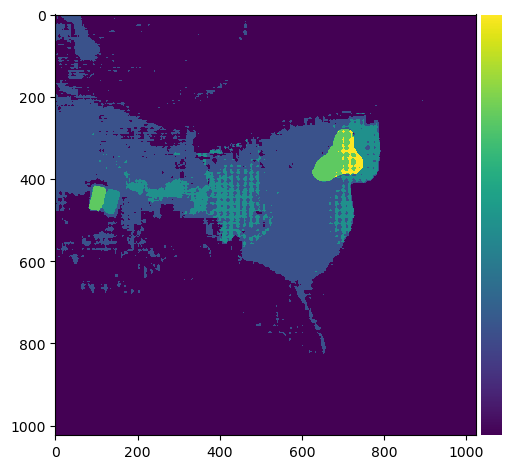

In [89]:
show_img(np.sum(masks[0][:, slice(1, None), ...].reshape((-1, *masks.shape[-2:])),  axis=0))

Cool ! même résultats qu'avec le Predictor

#### Remarques 
* que pasa avec un nombre differents de prompt par image ?
    * comment vectoriser ?
* generator en batch => intérêt de nms successifs (par batch de points, puis global) sur le nombre de masks finaux
    * tema full segment anything
* Statuer sur l'encoder de prompt a utiliser 

#### Infer with generator

In [ ]:
hs shape : torch.Size([4, 1024, 7, 256])
src shape : torch.Size([4, 1024, 4096, 256])
iou out shape : torch.Size([4, 7, 256])
masks tokens out shape : torch.Size([4, 4, 7, 256])

In [40]:
from segment_any_change.sa_dev_v0 import SamAutomaticMaskGenerator, SamPredictor
from segment_any_change.sa_dev_v0 import sam_model_registry as sam_model_registry_v0
device = "cuda"
model_type = "vit_b"

sam = sam_model_registry_v0[model_type](checkpoint=sam_model_small)
sam.to(device=device)

img_sample = load_img(df["A"].iloc[0])

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(img_sample)

2024-05-21 14:34:50,239 - INFO ::  build SAM


in points shape : torch.Size([64, 1, 2])
---- start predict torch ----
sparse emb : torch.Size([64, 2, 256])
dense emb : torch.Size([64, 256, 64, 64])
img emb : torch.Size([1, 256, 64, 64])
init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([64, 5, 256])
tokens shape : torch.Size([64, 7, 256])
src first interleave shape : torch.Size([64, 256, 64, 64])
src shape : torch.Size([64, 256, 64, 64])
src dense_prompt_embeddings : torch.Size([64, 256, 64, 64])
src add dense : torch.Size([64, 256, 64, 64])
out transformer
hs shape : torch.Size([64, 7, 256])
src shape : torch.Size([64, 4096, 256])
iou out shape : torch.Size([64, 256])
masks tokens out shape : torch.Size([64, 4, 256])
 mask_low : torch.Size([64, 4, 256, 256])
low mask  predict torch : torch.Size([64, 3, 256, 256])
low mask  predict torch : torch.Size([64, 3, 1024, 1024])
predict torch - mode auto output
out decoder masks raw shape : torch.Size([64, 3, 1024, 1024])
out decoder iou raw shape : torch.Size([64, 3

In [50]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

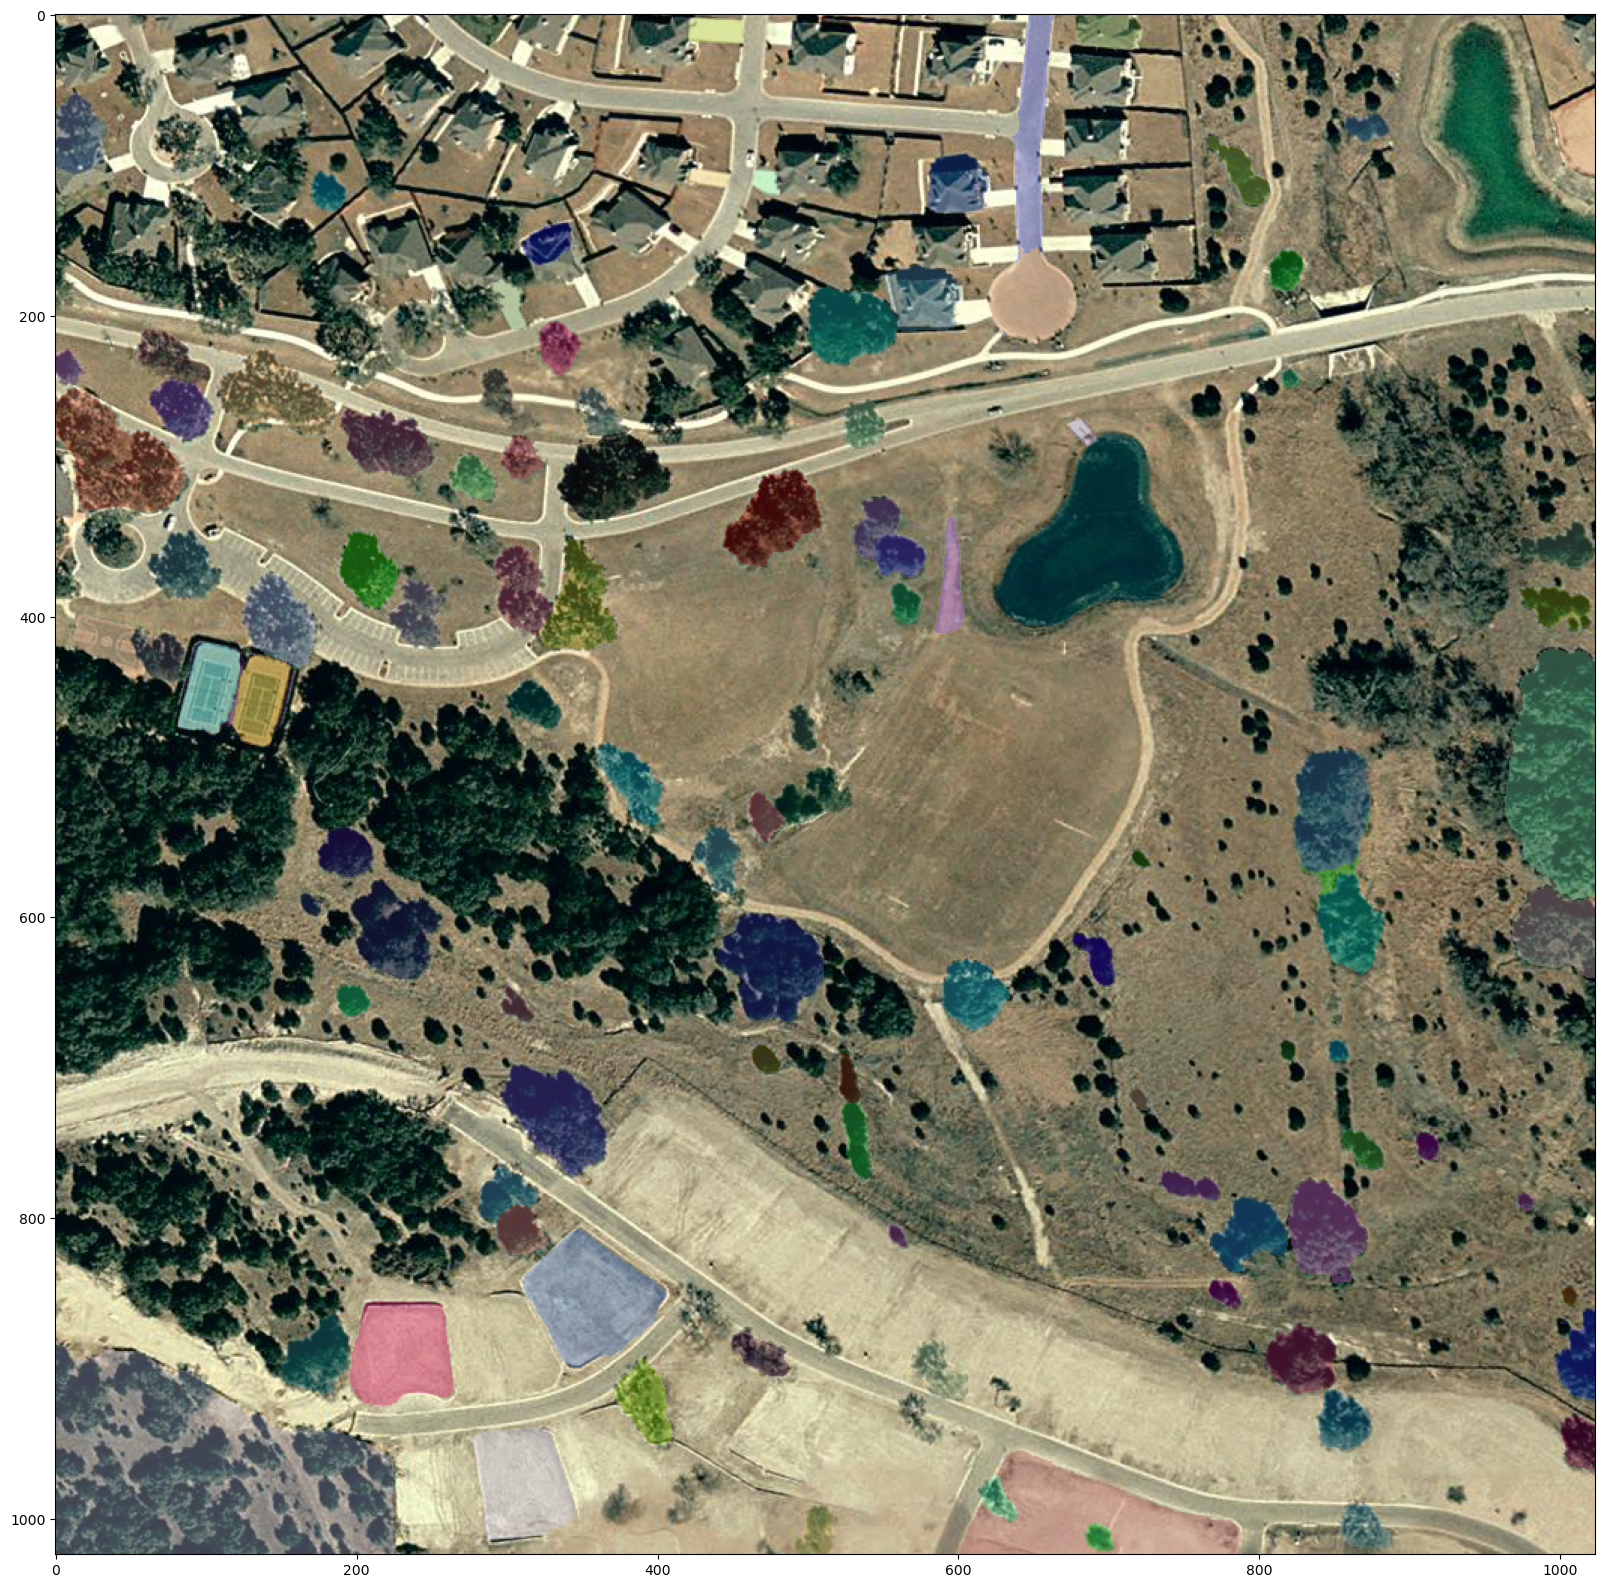

In [52]:
plt.figure(figsize=(20,20))
plt.imshow(img_sample)
show_anns(masks)

Modifier le batch size change l'inference ? Hope not

=> voir impact des nms apres le batch de points

## Annexes [DRAFT]

#### Details decoder tail - fusion and predictions heads

In [49]:
from torch import nn
from segment_any_change.sa_dev.modeling.common import LayerNorm2d

transformer_dim = 256

output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(
                transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
            ),
            LayerNorm2d(transformer_dim // 4),
            nn.GELU(),
            nn.ConvTranspose2d(
                transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2
            ),
            nn.GELU(),
        )

In [55]:
src[0,...].shape

torch.Size([1024, 256, 64, 64])

In [62]:
layer = nn.ConvTranspose2d(
                transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
            )
res = layer(src[0,...])

In [57]:
src= torch.as_tensor(
    np.ones((4, 1024, 256, 64, 64)), dtype=torch.float32, device=DEVICE
)

In [71]:
upscaled_embedding = torch.stack([output_upscaling(im) for im in src],dim=0)
upscaled_embedding.shape

torch.Size([4, 1024, 32, 256, 256])

In [64]:
from segment_any_change.sa_dev.modeling.mask_decoder import MLP

num_mask_tokens =4
transformer_dim = 256

output_hypernetworks_mlps = nn.ModuleList(
        [
            MLP(transformer_dim, transformer_dim, transformer_dim // 8, 3)
            for i in range(num_mask_tokens)
        ]
    )

In [70]:
mask_tokens_out = torch.as_tensor(np.ones((4, 1024, 4, 256)), dtype=torch.float32, device=DEVICE)
hyper_in_list = []

for i in range(num_mask_tokens):
    hyper_in_list.append(output_hypernetworks_mlps[i](mask_tokens_out[:, :, i, :]))
hyper_in = torch.stack(hyper_in_list, dim=2)
print(f"hyper in shape : {hyper_in.shape}")

hyper in shape : torch.Size([4, 1024, 4, 32])


In [74]:
b, n, c, h, w = src.shape

In [83]:
b, n, c, h, w = upscaled_embedding.shape
masks = (hyper_in @ upscaled_embedding.view(b, n, c, h * w)).view(b, n, -1, h, w)
print(f" mask_low : {masks.shape}")

 mask_low : torch.Size([4, 1024, 4, 256, 256])


In [95]:
iou_tokens_out = torch.as_tensor(np.ones((4, 1024, 256)), dtype=torch.float32, device=DEVICE)


iou_prediction_head = MLP(
            256, 256, output_dim=num_mask_tokens, num_layers=3
        )

iou_out = iou_prediction_head(iou_tokens_out)

In [96]:
iou_out.shape

torch.Size([4, 1024, 4])

In [ ]:
iou_prediction_head = MLP(
            transformer_dim, iou_head_hidden_dim, self.num_mask_tokens, iou_head_depth
        )

In [84]:
masks = masks.cpu().detach().numpy()

In [91]:
# multioutput masks
masks = masks[:, :, slice(1, None), :, :]

In [5]:
""" Example 5: [LBK SAM] Batched Inputs -> **Some Prompts** -> Multiple Mask Generation with filtering small and dulicated regions or holes [Very Hard] """


' Example 5: [LBK SAM] Batched Inputs -> **Some Prompts** -> Multiple Mask Generation with filtering small and dulicated regions or holes [Very Hard] '

In [6]:
img1 = np.array(Image.open(f"{data_path}/demo/sam/sam1.png"))
img2 = np.array(Image.open(f"{data_path}/demo/sam//sam2.png"))

#### Prompts

In [7]:
# prompt
input_point = np.array([[200, 900], [150, 150], [100, 450], [600, 300], [370, 640], [800, 800]],  dtype=np.float32)
input_label = np.array([1, 1, 1, 1, 1, 1],  dtype=np.float32)

In [8]:
coords_torch, labels_torch, box_torch, mask_input_torch = prepare_prompts(input_point, input_label)

#### Image

In [9]:
def prepare_image2(image, img_resolution=1024):
    trans = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(1024),
                                            torchvision.transforms.Resize(img_resolution)])
    image = torch.as_tensor(image).cuda()
    return trans(image.permute(2, 0, 1))

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


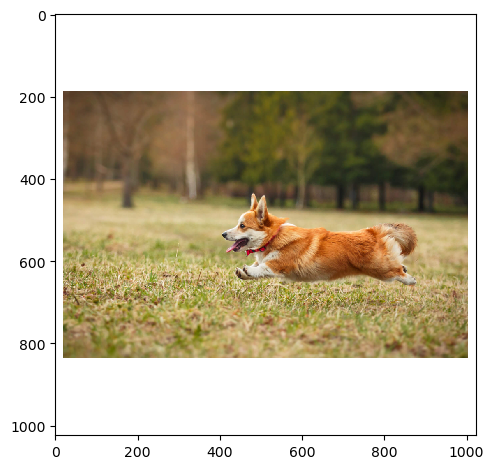

In [10]:
img1_tensor = prepare_image2(img1)
show_img(img1_tensor.permute(1, 2, 0).cpu().numpy(), show_axis=True)

In [11]:
img1[..., 1:].shape

(650, 984, 3)

/tmp/ipykernel_31586/4166607047.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) prepare_image.
  img1_tensor = prepare_image(img1[..., :-1])
/tmp/ipykernel_31586/4166607047.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) prepare_image.
  img2_tensor = prepare_image(img2[..., :-1])
2024-05-21 09:57:42,073 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


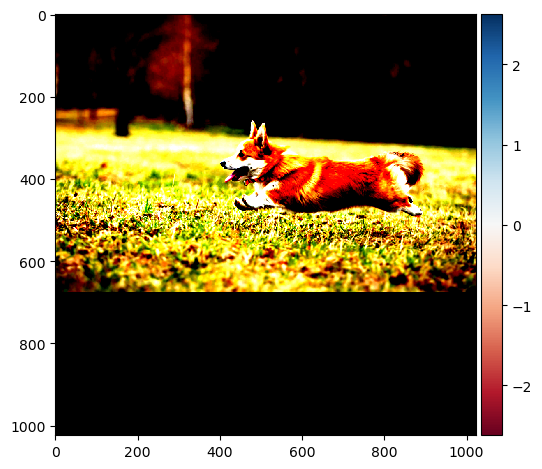

In [12]:
img1_tensor = prepare_image(img1[..., :-1])
img2_tensor = prepare_image(img2[..., :-1])
show_img(img1_tensor[0, ...].permute(1, 2, 0).cpu().numpy(), show_axis=True)

In [13]:
img1.shape, img1_tensor.shape

((650, 984, 4), torch.Size([1, 3, 1024, 1024]))

normalisation added

In [14]:
h, w = img1_tensor.shape[-2:]

padh = IMG_SIZE[0] - h
padw = IMG_SIZE[0] - w
x = F.pad(img1_tensor, (0, padw, 0, padh))

In [15]:
x.shape

torch.Size([1, 3, 1024, 1024])

In [16]:
img1_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [17]:
img1_tensor.device

device(type='cpu')

In [18]:
img1_tensor.shape

torch.Size([1, 3, 1024, 1024])

### Run batch

In [21]:
batched_input = [
     {
         'image': img1_tensor,
         'point_coords': coords_torch,
         'point_labels': labels_torch,
         'original_size': img1_tensor.shape[2:]
     },
     {
         'image': img2_tensor,
         'point_coords': coords_torch,
         'point_labels': labels_torch,
         'original_size': img2_tensor.shape[2:]
     }
]

In [22]:
img2_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [23]:
img1_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [24]:
%%time
input_images = torch.stack(
[x["image"] for x in batched_input], dim=0
).view(-1, 3, 1024, 1024)

image_embeddings = sam.image_encoder(input_images)

CPU times: user 2min 37s, sys: 26.9 s, total: 3min 4s
Wall time: 3.86 s


In [25]:
%%time
refined_masks = sam.bforward(batched_input, multimask_output=True)

AttributeError: 'Sam' object has no attribute 'bforward'

In [26]:
type(refined_masks)

list

In [27]:
len(refined_masks)

2

In [28]:
refined_masks[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

In [29]:
refined_masks[0]["masks"].shape

torch.Size([1, 3, 1024, 1024])

3 ???

#### Inference batch vectorized

In [42]:
n_points = 5
batch_points = np.tile(generate_grid_prompt(n_points), (batch_size*2, 1, 1))
batch_label = np.ones((batch_size*2, n_points*n_points))

In [43]:
coords_torch = torch.as_tensor(
batch_points, dtype=torch.float, device=DEVICE
)
labels_torch = torch.as_tensor(
    batch_label, dtype=torch.int, device=DEVICE
)   

In [44]:
coords_torch.shape, labels_torch.shape

(torch.Size([4, 25, 2]), torch.Size([4, 25]))

In [45]:
input_images = torch.cat([batch["img_A"], batch["img_B"]])

In [46]:
input_images = sam.preprocess(input_images)

In [47]:
input_images.shape

torch.Size([4, 3, 1024, 1024])

In [48]:
image_embeddings = sam.image_encoder(input_images)

In [49]:
image_embeddings.shape

torch.Size([4, 256, 64, 64])

In [75]:
# (coords_torch[:,:,None,:], labels_torch[...,None])
sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=(coords_torch[:,:,None,:], labels_torch[...,None]),
                boxes=None,
                masks=None,
            )

bs : 25
torch.Size([4, 25, 0, 256])
point shape raw torch.Size([4, 25, 1, 2])
padding_point shape raw torch.Size([4, 25, 1, 2])
concat points and padding shape torch.Size([4, 25, 2, 2])
emb points
torch.Size([4, 25, 2, 256])
torch.Size([4, 25, 2, 256])
torch.Size([4, 25, 0, 256])
torch.Size([4, 25, 2, 256])
torch.Size([4, 25, 2, 256])


##### check with classic non batch implementation

In [24]:
model_type = "vit_b"
sam_raw = load_sam(model_type=model_type, version="raw")

2024-05-21 11:20:28,325 - INFO ::  build SAM


In [59]:
s_emb, d_emb = sam_raw.prompt_encoder(
                points=(coords_torch[0][:,None,:], labels_torch[0][...,None]),
                boxes=None,
                masks=None,
            )

In [71]:
# (coords_torch[:,:,None,:], labels_torch[...,None])
s_emb, d_emb = [], []
for coord, label in zip(coords_torch, labels_torch):
    sparse_embeddings, dense_embeddings = sam_raw.prompt_encoder(
                    points=(coord[:,None,:], label[...,None]),
                    boxes=None,
                    masks=None,
                )
    s_emb.append(sparse_embeddings)
    d_emb.append(dense_embeddings)

In [73]:
len(s_emb)

4

In [78]:
sparse_embeddings = sparse_embeddings.flatten(0, 1)
sparse_embeddings.shape

torch.Size([100, 2, 256])

In [80]:
s_emb = torch.stack(s_emb, dim=0).flatten(0, 1)
s_emb.shape

torch.Size([100, 2, 256])

In [86]:
assert all([s_emb[i].cpu().detach().numpy().tolist() == sparse_embeddings[i].cpu().detach().numpy().tolist() for i in range(coords_torch.shape[0])]) == True

Implementation doesn't allow batch inference for multi images and multi prompts in a vectorized manner ===> edit 21-05 : we don't care because image is not implicated in prompt encoder.

In [26]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([4, 25, 2, 256]), torch.Size([25, 256, 64, 64]))

In [27]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([4, 25, 2, 256]), torch.Size([25, 256, 64, 64]))

In [28]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([4, 25, 2, 256]), torch.Size([25, 256, 64, 64]))

It should have a dimension for each prompt ! =>256 pts and extra dim with padding

#### mask decoder inference loop

In [29]:
m =sam.prompt_encoder.get_dense_pe()

In [30]:
m.shape

torch.Size([1, 256, 64, 64])

#### mask decoder inference vectorized

In [87]:
print(image_embeddings.shape)
print((sam.prompt_encoder.get_dense_pe()).shape)
print(sparse_embeddings.shape)
print(dense_embeddings.shape)

torch.Size([4, 256, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([100, 2, 256])
torch.Size([25, 256, 64, 64])


In [88]:
low_res_masks, iou_predictions = sam.mask_decoder.predict_masks(
    image_embeddings=image_embeddings,
    image_pe=sam.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    #multimask_output=True,
)

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([100, 2, 5, 256])


RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [74]:
masks = low_res_masks.view(100, -1, 256, 256)

In [75]:
print(masks.shape)
mask_slice = slice(1, None)
masks = masks[:, mask_slice, :, :]

torch.Size([100, 4, 256, 256])


In [76]:
masks.shape

torch.Size([100, 3, 256, 256])

In [77]:
masks = masks.view(4, 25, 3, 256, 256).permute(0, 1, 3, 4, 2).cpu().detach().numpy()

In [79]:
masks.shape

(4, 25, 256, 256, 3)

In [83]:
masks_img_1 = np.sum(masks[0], axis=0)
masks_img_2 = np.sum(masks[1], axis=0)

In [87]:
masks_img_1.shape

(256, 256, 3)

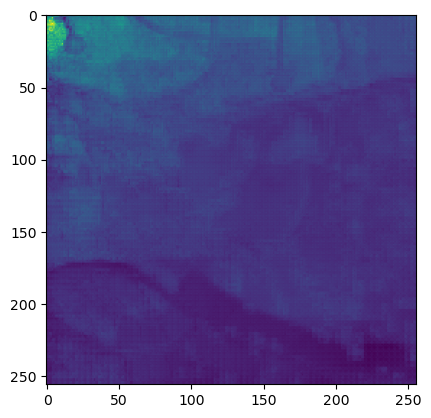

In [88]:
plt.imshow(masks_img_1[...,0])

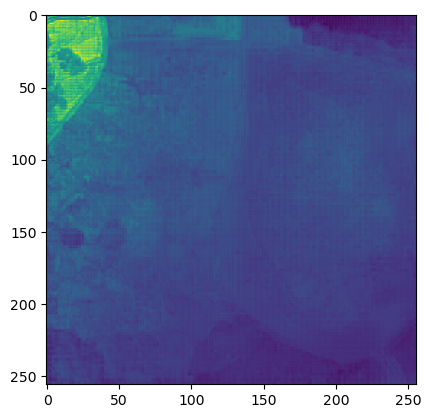

In [89]:
plt.imshow(masks_img_2[...,0])

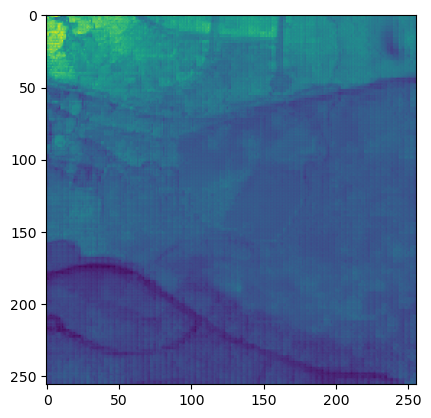

In [72]:
plt.imshow(masks[0])

* batch inference not working : issue with expand / upscaling ??

In [65]:
masks[0, :, :, :].cpu().detach().numpy().transpose(1, 2, 0)[0].shape

(256, 3)

In [ ]:
np.sqrt(8192)

In [ ]:
from torch import nn
from segment_any_change.sa_dev.modeling.common import LayerNorm2d

transformer_dim = 256
layer =  nn.ConvTranspose2d(
        transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
    )
output_upscaling = nn.Sequential(
    nn.ConvTranspose2d(
        transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
    ),
    LayerNorm2d(transformer_dim // 4),
    nn.ConvTranspose2d(
        transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2
    ),
)

In [ ]:
src = torch.as_tensor(
    np.random.random((100, 256, 64, 64)), device=DEVICE, dtype=torch.float32
)

In [47]:
out = layer(src)

In [48]:
out.shape

torch.Size([100, 64, 128, 128])

In [55]:
b, c, h, w = src.shape
n = 25
output_upscaling(src).view(b, -1, h * w).view(b, n, -1, h, w)

RuntimeError: shape '[100, 25, -1, 64, 64]' is invalid for input of size 209715200

## Test transformer

In [16]:
# src : torch.Size([64, 256, 64, 64])
# pos_src : torch.Size([64, 256, 64, 64])
# tokens : torch.Size([64, 7, 256])

src = torch.as_tensor(
    np.random.random((4, 64, 256, 64, 64)), device=DEVICE, dtype=torch.float32
)
pos_src = torch.as_tensor(
    np.random.random((4, 64, 256, 64, 64)), device=DEVICE,  dtype=torch.float32
)
tokens = torch.as_tensor(
    np.random.random((4, 64, 7, 256)), device=DEVICE,  dtype=torch.float32
)

In [17]:
src[0].flatten(2).permute(0, 2, 1).shape

torch.Size([64, 4096, 256])

In [18]:
pos_src.flatten(0, 1).flatten(2).permute(0, 2, 1).shape

torch.Size([256, 4096, 256])

In [19]:
src.flatten(0, 1).flatten(2).shape

torch.Size([256, 256, 4096])

In [21]:
b, n, c, h, w = src.shape

hs, src  = sam.mask_decoder.transformer(
    src, pos_src, tokens
)

In [22]:
hs.shape

torch.Size([256, 7, 256])

In [23]:
src.shape

torch.Size([256, 4096, 256])

In [25]:
src.transpose(1, 2).view(b,n, c, h, w).shape

torch.Size([4, 64, 256, 64, 64])

In [33]:
64*64

4096

In [53]:
src = torch.as_tensor(
    np.random.random((16, 256, 64, 64)), device=DEVICE
)

In [58]:
def interpolate(x, w, h):
    from torch import nn
    height, width = x.shape[2:]

    # we add a small number to avoid floating point error in the interpolation
    # see discussion at https://github.com/facebookresearch/dino/issues/8
    w0, h0 = w + 0.1, h + 0.1
    x = nn.functional.interpolate(
        x,
        scale_factor=(w0 / height, h0 / width),
        mode='bicubic',
    )
    return x

In [62]:
src.shape

torch.Size([16, 256, 64, 64])

In [61]:
dense_embeddings.shape

torch.Size([4, 256, 64, 64])

In [67]:
sparse_embeddings.shape

torch.Size([4, 26, 256])

In [70]:
dense_embeddings.expand(
            src.size(0), -1, -1, -1
        )

RuntimeError: The expanded size of the tensor (16) must match the existing size (4) at non-singleton dimension 0.  Target sizes: [16, -1, -1, -1].  Tensor sizes: [4, 256, 64, 64]

In [72]:
torch.repeat_interleave(dense_embeddings, src.shape[0] // dense_embeddings.shape[0], dim=0).shape

torch.Size([16, 256, 64, 64])

In [59]:
src + torch.repeat_nterkeae(dense_embeddings, *src.shape[2:])

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [131]:
low_res_masks.shape

torch.Size([4, 3, 256, 256])

In [93]:
masks = sam.postprocess_masks(
                low_res_masks,
                input_size=IMG_SIZE,
                original_size=IMG_SIZE,
            )

In [94]:
masks = masks.cpu().detach().numpy()

In [95]:
masks.shape

(4, 3, 1024, 1024)

Wrong dimensions : il faut

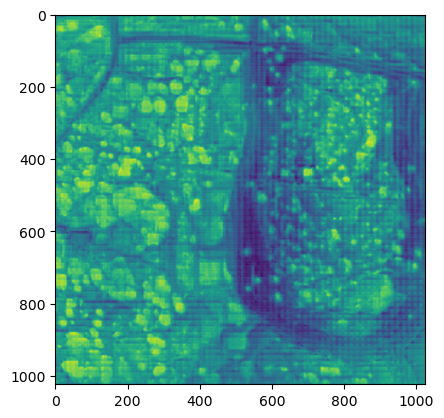

In [96]:
plt.imshow(masks[1][2])

In [83]:
masks = masks.reshape((4, 1024, -1))

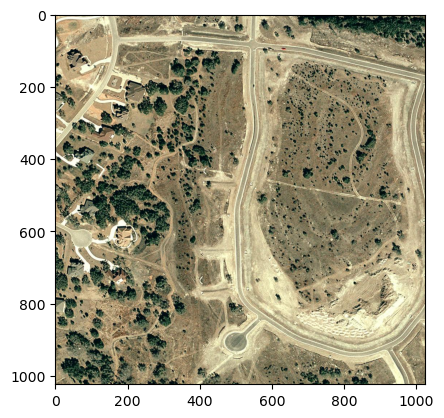

In [85]:
plt.imshow(batch["img_A"][1].permute(1, 2, 0))

In [ ]:
torch.cat([batch["img_A"], batch["img_B"]], axis=0).shape

In [38]:
src = torch.repeat_interleave(image_embeddings[0,...], 2, dim=0)


In [39]:
src.shape

torch.Size([512, 64, 64])

In [35]:
res = interpolate(dense_embeddings, *src.shape[2:])
res.shape

torch.Size([2, 256, 64, 64])

In [40]:
src + dense_embeddings

RuntimeError: The size of tensor a (512) must match the size of tensor b (256) at non-singleton dimension 1

In [33]:
img1_tensor.ndim

4

### Transform

In [21]:
long_side_length = 1024
oldh = 1050
oldw = 1100

In [22]:
scale = long_side_length * 1.0 / max(oldh, oldw)
newh, neww = oldh * scale, oldw * scale
print(newh)
print(neww)

977.4545454545455
1024.0


### decoder token dimensions

In [73]:
iou_token = nn.Embedding(1, 256)
mask_tokens = nn.Embedding(3, 256)

In [74]:
mask_tokens.weight.shape

torch.Size([3, 256])

In [75]:
# Concatenate output tokens
output_tokens = torch.cat([iou_token.weight, mask_tokens.weight], dim=0)
print(output_tokens.shape)
output_tokens = output_tokens.unsqueeze(0).expand(sparse_embeddings.size(0), -1, -1)
print(output_tokens.shape)
tokens = torch.cat((output_tokens, sparse_embeddings), dim=1)
print(tokens.shape)

torch.Size([4, 256])
torch.Size([4, 4, 256])
torch.Size([4, 1029, 256])


In [81]:
# Expand per-image data in batch direction to be per-mask
src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
src.shape

torch.Size([16, 256, 64, 64])

In [79]:
# Expand per-image data in batch direction to be per-mask
src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
src = src + dense_embeddings

pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [77]:
torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0).shape

torch.Size([16, 256, 64, 64])

In [ ]:
torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)

In [ ]:
def show_masks(masks, plt, alpha=0.7):
    if len(masks) == 0: return
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_masks:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
    ax.imshow(img)
    return img

def show_points(coords, labels, ax, marker_size=50):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   
    
    
# image mask generation visualization
for i, mask in enumerate(refined_masks[0]):
    plt.figure(figsize=(5,5))
    plt.imshow(img1_tensor.permute(1,2,0).cpu().numpy())
    show_mask(mask.cpu().numpy(), plt.gca())
    # show_box(input_box, plt.gca(), plt)
    show_points(input_point.cpu().numpy(), input_label.cpu().numpy(), plt.gca())
    plt.title(f"LBK Refined Mask {i+1}", fontsize=18)
    plt.axis('on')
    plt.show()


In [ ]:

for i, mask in enumerate(refined_masks[1]):
    plt.figure(figsize=(5,5))
    plt.imshow(img2_tensor.permute(1,2,0).cpu().numpy())
    show_mask(mask.cpu().numpy(), plt.gca())
    # show_box(input_box, plt.gca(), plt)
    show_points(input_point.cpu().numpy(), input_label.cpu().numpy(), plt.gca())
    plt.title(f"LBK Refined Mask {i+1}", fontsize=18)
    plt.axis('on')
    plt.show()


#### Repeat_interleaves vs expand

In [28]:
t = torch.as_tensor(np.array([[1, 2, 3], [1, 2, 3]]))
print(t)
print(t.shape)
print("----")
print(t.unsqueeze(0).expand(3, -1, -1))
print(t.unsqueeze(0).expand(3, -1, -1).shape)
print("----")

tensor([[1, 2, 3],
        [1, 2, 3]])
torch.Size([2, 3])
----
tensor([[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]])
torch.Size([3, 2, 3])
----


In [29]:
t = torch.as_tensor(np.array([[1, 2, 3], [1, 2, 3]]))
print(t)
print(t.shape)
print("----")
print(torch.repeat_interleave(t, 3, dim=1))
print(torch.repeat_interleave(t, 3, dim=1).shape)
print("----")

tensor([[1, 2, 3],
        [1, 2, 3]])
torch.Size([2, 3])
----
tensor([[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 1, 1, 2, 2, 2, 3, 3, 3]])
torch.Size([2, 9])
----
